# Langevin
##  Theory
- integration schemes that include a thermostat
- full algorithms to simulate molecular dynamics in the N V T ensemble
- stochastic dynamics, based on Langevin dynamics
$$
dp = M^{-1}v \,\text{d}t\\
dv = -\nabla \phi(p)\,\text{d}t- \gamma v \,\text{d}t + \sigma M^{1/2}\,\text{d}W
$$ 
     - the first part of the equation is equal to Newtonian dynamics
     - and the function of the last two terms is to act as a thermostat (friction + noise)

whereby:
- $W = W (t)$ is a vector of 3N independent Wiener processes ? => results in the matrix of noise intensities and a vector of uncorrelated Gaussian random numbers $R_t$, 
* $\gamma > 0$ is a free (scalar) parameter the isotopic friction constant which couple the system to the bath (damping parameter), 
* choosing $ \sigma = \sqrt{2\gamma \beta ^{-1}}$ it is possible to show that the unique probability distribution sampled by the dynamics is the canonical (Gibbs-Boltzmann) density

integration by discretizing in time using a second-order numerical method  according to 
$$\hat{L}*= L*_{\text{LD}}+ \delta t ^2 L*_2 + O(\delta t^3)$$
instead of Taylor series expansion

for the BAOAB method the Langevin dynamics are breaked into three pieces
$$
\left[ \begin{matrix}dp\\dv\end{matrix}\right]= \left[ \begin{matrix}M^{-1}v\\0\end{matrix}\right]\text{d}t+\left[ \begin{matrix}0\\-\nabla\phi(p)\end{matrix}\right]\text{d}t
+\left[ \begin{matrix}0\\-\gamma v \text{d}t + \sigma M^{1/2}\text{d}W\end{matrix}\right]$$

- firts part is labelled A, second as B and third O
O piece is associated with an Ornstein-Uhlenbeck equation with “exact” solution:
$$v(t) = e^{-\gamma t} v(0)+ \frac{\sigma}{\sqrt{2\gamma}}\sqrt{1-e^{-2\gamma t}}M^{1/2}R_t$$
where $R_t$ is a vector of uncorrelated noise processes

- the sequence is given through BAOAB
- to ensure the method is symmetric  all “A” and “B” parts in BAOAB are integrated for a half timestep 

## Algorithm
1. defining parameters
      - number of time steps
      - number of particles
      - number of dimension
2. prepering the time iteration
      - creating positiion, velocity and acceleration container
      - initialization by adding the start configuration
      - 
3. time iteration
      - define iteraration scheme (loop p=t-1)
      - langevin approximation
          - B
          - A
          - O
          - A
          - B
      - writing the output array
4. returning position_matrix, velocity_matrix, acceleration_matrix

### Advantage
-
-




In [1]:
%matplotlib notebook
import numpy as np
import timeit
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
%load_ext line_profiler

#### open system

In [24]:
def potential_gradient(p,k=0):
    return k*p

In [25]:
def langevin(potential_gradient, position_init, velocity_init, mass, total_time, time_step, damping, beta, boxsize, pbc=True):
    
    """
    This function realise the integration scheme of Langevin dynamics with the BAOAB-Algorithm. 
    This scheme includes a thermostat thus solving ODEs leads to a MD-Simulation in the NVT-ensemble.
    
    Arguments:
        potential_gradient (function): computes potential gradient for particle-positions 
        position_init (numpy.ndarray(n, dim)): initial configuration in dim dimensions
        velocity_init (numpy.ndarray(n, dim)): initial velocity in dim dimensions
        mass (numpy.ndarray(n)): mass of each particle
        total_time (int): total time of integration
        time_step (float): step size for integration 
        damping (float): isotopic friction constant (couple the system to the bath), zero for not coupled
        beta (float): inverse temperature
        pbc (boolean): periodic boundary conditions (True) or not periodic (False)
        
    Returns:
        position_matrix (numpy.ndarray(size, n, dim)): configuraiton trajectory
        velocity_matrix (numpy.ndarray(size, n, dim)): velocity trajectory
        acceleration_matrix (numpy.ndarray(size, n, dim)): acceleration trajectory
       
    """
    size = int(total_time/time_step)    
    n = len(position_init)              
    dim = position_init.shape[-1]       
    m = mass
    p_min, p_max = boxsize[0], boxsize[1]
    position_matrix, velocity_matrix, acceleration_matrix = np.zeros((size, n, dim)), np.zeros((size, n, dim)), np.zeros((size, n, dim))
    position_matrix[0], velocity_matrix[0], acceleration_matrix[0] = position_init, velocity_init, potential_gradient(position_init)
    R_t = np.random.randn(n, dim)
    fri = np.exp(-damping*time_step)
    noi = np.sqrt((1-fri**2)/(beta*m))
    for t in range(1, size):
        p = position_matrix[t-1]
        v = velocity_matrix[t-1]
        a = acceleration_matrix[t]
        gp = potential_gradient(p)
        v_new = v - time_step/(2*m) * gp                     
        p_new = p + time_step/2 *v_new                        
        if pbc:
            p_new = p_new - (p_new > p_max)*(p_max-p_min)
            p_new = p_new + (p_new < p_min)*(p_max-p_min)
        v_new = fri*v_new + noi* R_t                          
        p_new = p_new + time_step/2 *v_new                    
        if pbc:
            p_new = p_new - (p_new > p_max)*(p_max-p_min)
            p_new = p_new + (p_new < p_min)*(p_max-p_min)
        gp = potential_gradient(p_new)
        v_new = v_new - time_step/(2*m) * gp                  
        a = - gp/m
        position_matrix[t], velocity_matrix[t], acceleration_matrix[t] = p_new, v_new, a
    return position_matrix, velocity_matrix, acceleration_matrix

<IPython.core.display.Javascript object>


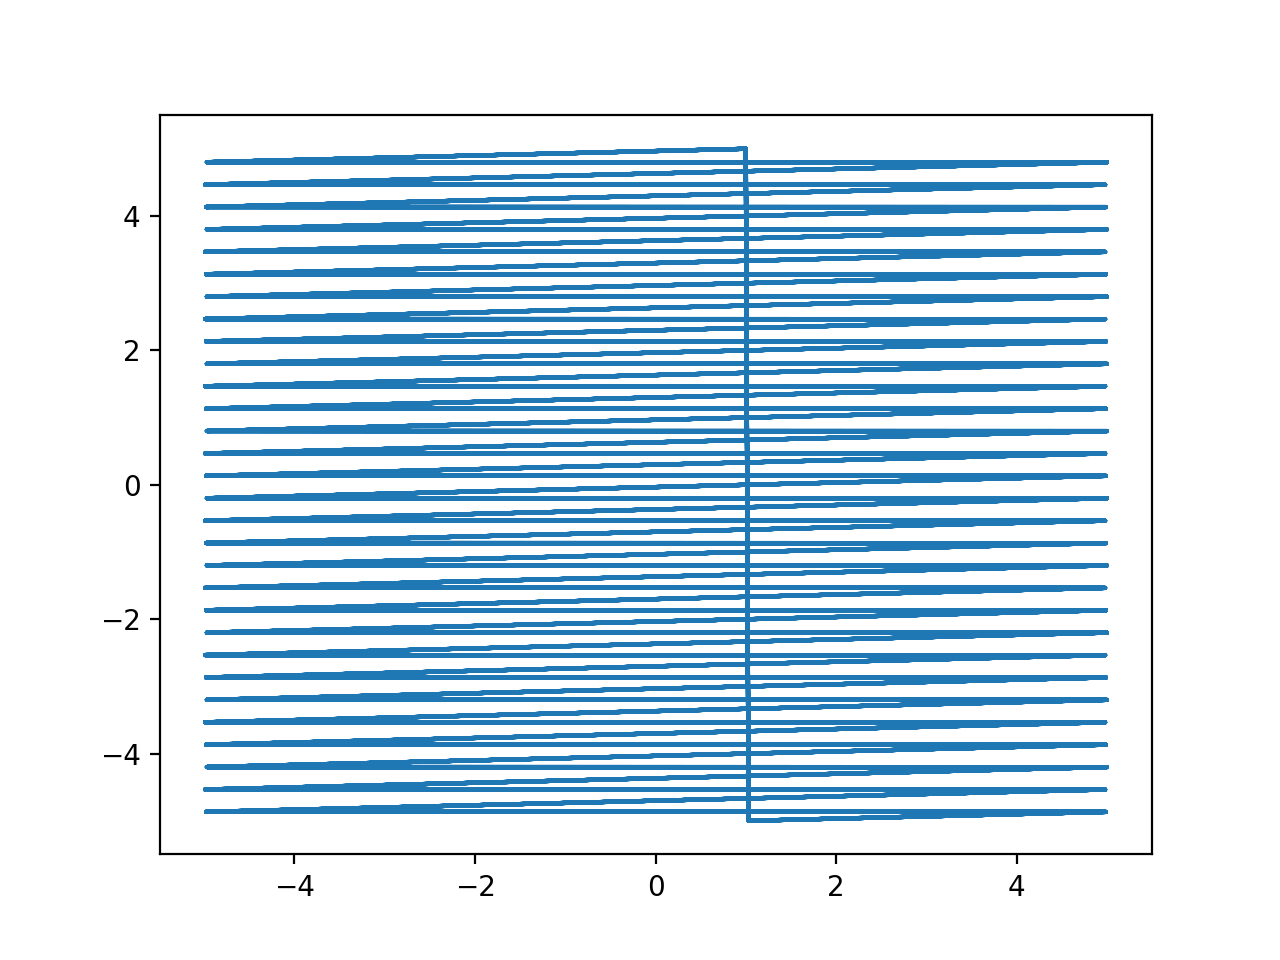

In [27]:
################################### short testing ###########################################
boxsize = (-5, 5)
###### input 2D ######
p_0 = np.array([[1., 0.]])
v_0 = np.array([[30., 1.]])
m = np.array([[1., 1.]])

###### input 3D ######
#p_0 = np.array([[5., 0., 0.], [0., 1., 0.]])
#v_0 = np.array([[0., 0., 0.], [0., 0., 0.]])
#m = np.array([[1., 1., 1.], [1., 1., 1.]])

###### energy conservation ######
res = langevin(potential_gradient, p_0, v_0, m, 100., 0.001, 0., 1.0, boxsize, pbc=True)
#res
#print(a[0][:,0,0])
plt.plot(res[0][:,0, 0], res[0][:,0, 1])

##### kinetic energy ######
#np.dot(res[1][:,0,0],res[0][:,0,1])*2/3==1 #???


## timing

#### loop p = t-1
algorithm where p and v needed to calculate the new p and v equals the last timestep
- total run time :  `%timeit`
     - 

- line time profiling :  `%lprun`
the most time-consuming step is to calculate the next p and v; 
followed by the calculation of the gp/gp_new and riting of the output arrays 
   - ``
        -  
   - ``
        -

on average the loop p=t-1 is 3.8 %Time faster in calculating p_new than p=t+1

### result 
-

In [ ]:
###################################  timing ################################### 
### loop p = t-1 ###
%lprun -f langevin langevin(potential_gradient, p_0, v_0, m, 100., 0.001, 0., 1.0, pbc=True)
%timeit  -n 10 -r 10 langevin(potential_gradient, p_0, v_0, m, 100., 0.001, 0., 1.0, pbc=True)



#### closed system

In [ ]:
def potential_gradient(p, k=1):
    return k*p

def box_potential(p, p_max):
    p_r = p_max - p_max/4
    p_l = p_max/4
    V_r = 4 * np.abs(p - p_r)**2*np.heavisiede(np.abs(p - p_r))
    V_l = 4 * np.abs(p - p_l)**2*np.heavisiede(np.abs(p - p_l))
    return V_r + V_l

In [ ]:
def langevin(potential_gradient, position_init, velocity_init, mass, total_time, time_step, damping, beta):
    size = int(total_time/time_step)    # number of time steps
    n = len(position_init)              # number of particles
    dim = position_init.shape[-1]       # number of dimension
    m = mass
    # creating positiion, velocity and acceleration container
    position_matrix, velocity_matrix, acceleration_matrix = np.zeros((size, n, dim)), np.zeros((size, n, dim)), np.zeros((size, n, dim))
    # initialization by adding the start configuration
    position_matrix[0], velocity_matrix[0], acceleration_matrix[0] = position_init, velocity_init, potential_gradient(position_init)
    # time iteration
    for t in range(1, size):
        # rename # kostet das rechenleistung ? bennenung lieber von anfang anders?
        p = position_matrix[t-1]
        v = velocity_matrix[t-1]
        a = acceleration_matrix[t]
        gp = potential_gradient(p)
        R_t = np.random.randn(n, dim)
        # langevin approximation
        fri = np.exp(-damping*time_step)
        noi = np.sqrt((1-fri**2)/(beta*m))
        v_new = v - time_step/(2*m) * gp                      # B
        p_new = p + time_step/2 *v_new                        # A
        v_new = fri*v_new + noi* R_t                          # O
        p_new = p_new + time_step/2 *v_new                    # A
        gp = potential_gradient(p_new)
        v_new = v_new - time_step/(2*m) * gp                  # B
        a = - gp/m
        # write in pos, vel and acc container
        position_matrix[t], velocity_matrix[t], acceleration_matrix[t] = p_new, v_new, a
    # returning position and velocety container
    return position_matrix, velocity_matrix, acceleration_matrix

In [ ]:
# testing 
#p_0 = np.array([[1., 0.]])
#v_0 = np.array([[0., 0.]])
p_max = np.array([[2., 3., 2.], [2., 3., 2.]])
p_0 = np.array([[1., 0., 0.], [1., 0., 0.]])
v_0 = np.array([[0., 0., 0.], [0., 0., 0.]])
#m = np.array([1.])
m = np.array([[1., 1., 1.], [1., 1., 1.]])

res = langevin(potential_gradient, p_0, v_0, m, 100., 0.001, 0., 1.)
res
#print(a[0][:,0,0])
plt.plot(res[0][:,0, 0], res[1][:,0,0])